### Links 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Loding Usefull Modules 

In [2]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch.onnx

In [4]:
torch.__version__

'1.6.0'

### Loading User_defined modules

In [5]:
import albumentations as A

In [6]:
import model_utility.data_utils as dutils
import model_utility.model_utils as mutils
import model_utility.plot_utils as putils 
import model_utility.regularization as regularization
import model_utility.alb_utils as alb

In [7]:
import tsai_models.model_cifar as model_cifar
import tsai_models.models as mod

import albumentations as A
from albumentations.pytorch import ToTensor

import grad_cam.grad_cam_viz as grad_cam_viz

# Check GPU avaiability

In [8]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [9]:
cuda = torch.cuda.is_available()
print(cuda)

True


# Downloading the dataset

In [10]:
import zipfile
import os
import requests
from io import StringIO, BytesIO

def download_dataset(url, zipfile_name):
    if (os.path.isdir(zipfile_name)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
    print('Downloading and extraction completed')

In [11]:
TINY_IMAGENET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
ZIP_FILENAME = "tiny-imagenet-200"
download_dataset(TINY_IMAGENET_URL,ZIP_FILENAME)

Images already downloaded...


In [12]:
!ls

EVA5_session_12.ipynb  model_utility	  tiny-imagenet-200_eva
grad_cam	       __pycache__	  TinyImagenetDataset.py
gradcam		       readme.md	  tsai_models
model_log	       tiny-imagenet-200


## Tiny_Net Data Prep

In [13]:
ORIG_IMAGE_DIR = "./tiny-imagenet-200"
DEST_IMAGE_DIR = "./tiny-imagenet-200_eva"
TRAIN_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"train")
VAL_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"val")

In [14]:
from TinyImagenetDataset import TinyImagenetDataset

In [15]:
tiny_imagenet = TinyImagenetDataset(ORIG_IMAGE_DIR)

In [16]:
tiny_imagenet.create_imagefolder(DEST_IMAGE_DIR)

Dataset is already ready and existing..


In [17]:
classes = tuple(tiny_imagenet.class_name_list)
classes[:5]

('Egyptian cat', 'reel', 'volleyball', 'rocking chair', 'lemon')

In [18]:
means, stds = [0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]
print("means: {}".format(means))
print("stds: {}".format(stds))

means: [0.4802, 0.4481, 0.3975]
stds: [0.2302, 0.2265, 0.2262]


# Load dataset

In [19]:
path = os.getcwd()
path

'/home/jd/Desktop/EVA5/session12'

In [20]:
import albumentations as A

In [21]:
batch_size = 128

In [22]:
train_transforms, test_transforms = alb.get_data_transform('./')

In [23]:
config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=4,
    epochs=50
)

In [24]:
train_loader, test_loader = alb.get_dataloader_img_folder(
                                            TRAIN_IMAGE_DIR, VAL_IMAGE_DIR,
                                            train_transforms, test_transforms, 
                                            batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True


# Data mage Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

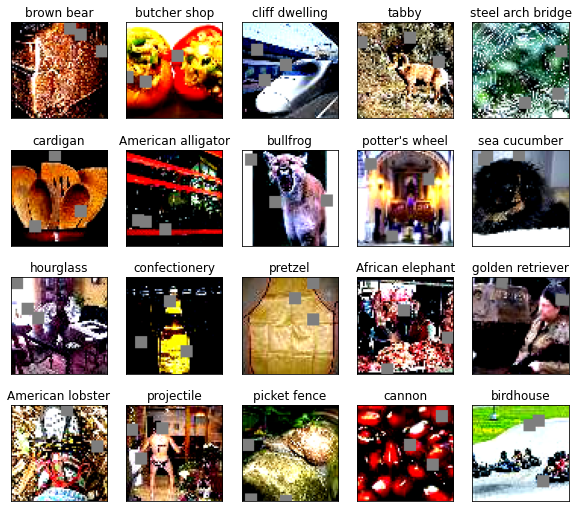

In [25]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader,save_path ='model_log/images')

### Model stracture

In [26]:
model = mod.ResNet18_tin()

In [27]:
mutils.model_summary(model, device, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

# Build and train model

In [28]:
from tqdm import tqdm

In [29]:
# build and train the model
model_name = "Tiny_image_net"
EPOCHS = 5
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model, 
                                                            device, 
                                                            trainloader=train_loader, 
                                                            testloader=test_loader, 
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=False,
                                                            L2_penalty_val=0.0005)

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/602 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 3.95 GiB total capacity; 2.89 GiB already allocated; 14.88 MiB free; 2.95 GiB reserved in total by PyTorch)

# Test Accuracy

In [ ]:
mutils.get_test_accuracy(model, device, test_loader)

### Class level Accuracy

In [ ]:
mutils.class_based_accuracy(model, device, classes, test_loader)

# Visualization

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name, 
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history",path = 'model_log/images')

# Misclassified images

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification(model, 
                        device, 
                        classes,
                        testloader=test_loader,
                        path = 'model_log/images',
                        typ_of_file = 'test',
                        num_of_images = 20,
                        save_filename="model_misclassified")

In [ ]:
import gradcam.gradcam_abs as gradcamAbs1 

In [ ]:
means,stds = alb.find_stats('model_log/cifar_10_data/')

In [ ]:
config = dict(model_type='resnet', arch=model, layer_name='layer4')
gcam = gradcamAbs1.GradCamAbs(device, config, means, stds)

In [ ]:
gradcam_images, pred_results = gcam.applyOnMisclassifiedImages(dataloader=test_loader, num_of_images=25)

In [ ]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result_details")